<h1> Chaotic photon orbits and shadows of a non-Kerr <br> object described by the Hartle-Thorne spacetime <h1>

These notebooks accompany the paper
"Chaotic photon orbits and shadows of a non-Kerr object described by the Hartle-Thorne spacetime" ([arXiv:2111.09367 [gr-qc]](https://arxiv.org/abs/2111.09367)) and give a demonstration of the calculations present in the paper. 
The code is in some extent based on programs available as examples in the [SageManifolds project's](https://sagemanifolds.obspm.fr/examples.html) website. 

<h2> Sticky Light Rays <h2>

We follow a light ray that is launched at $r_0=40M$ and with impact parameters $b=4.304332$, $\alpha=0.005402$.

In [1]:
%display latex
version()



'SageMath version 9.2, Release Date: 2020-10-24'

In [2]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import multiprocessing as mp


In [3]:
M = Manifold(4, 'M', latex_name=r'\mathcal{M}', structure='Lorentzian')





X.<t,r,th,ph>=M.chart(r"t r:(2.001,+inf) th:(0,pi):\theta ph:(0,2*pi):periodic\phi")

X.coord_range()

t: (-oo, +oo); r: (2.00100000000000, +oo); th: (0, pi); ph: [0, 2*pi] (periodic)

In [4]:
var('m,b,a,Ω,q', domain='real')
g = M.metric()
m=1


In [5]:
g[0,0] =((2*m)/r - 1) + (1/(16*m^2*r^5))*(a^2)*(((64*m^6)*r)*(sin(th)^2) - (32*m^6)*r -(1 - 3*(cos(th)^2))*(((16*m^5)*(2*m - r))*(m + r) - ((5*r^3)*q)*(((2*m)*(m - r))*(2*m^2 - 3*r^2 + (6*m)*r) + ((3*r^2)*(r - 2*m)^2)*log(1 - (2*m)/r)))) 

g[0,3] = -2*a*(m^2)*((sin(th))^2)/r

##
g[1,1]= 1/(1 - (2*m)/r) - (1/(32*m^2*r^3*(r - 2*m)^2))*(a^2)*((2*m)*(80*m^6 + (8*m^4)*r^2 - (24*m^5)*r + ((10*m^3)*r^3)*q + ((20*m^2)*r^4)*q - ((45*m)*r^5)*q + (15*r^6)*q) + (((15*r^5)*(r - 2*m)^2)*q)*log(1 - (2*m)/r) + (3*cos(2*th))*((2*m)*(80*m^6 + (8*m^4)*r^2 - (56*m^5)*r + ((10*m^3)*r^3)*q + ((20*m^2)*r^4)*q - ((45*m)*r^5)*q + (15*r^6)*q) + (((15*r^5)*(r - 2*m)^2)*q)*log(1 - (2*m)/r))) 



g[2,2] =r^2 + (1/8)*((a^2*r^2)*(3*(cos(th)^2) - 1))*(-(((8*m^3)*(2*m + r))/r^4) - (5*q)*(-((2*m)/r) + (3*r)/m + ((3*r^2)/(2*m^2) - 3)*log(1 - (2*m)/r) + 3))



g[3,3] = (r^2)*(sin(th)^2) + (1/8)*(((a^2*r^2)*(3*(cos(th)^2) - 1))*(-(((8*m^3)*(2*m+ r))/r^4)-(5*q)*(-((2*m)/r) + (3*r)/m + ((3*r^2)/(2*m^2) - 3)*log(1 - (2*m)/r) + 3)))*(sin(th)^2)

g.display()

g = (2/r + 1/16*(64*r*sin(th)^2 - (5*(3*(r - 2)^2*r^2*log(-2/r + 1) + 2*(3*r^2 - 6*r - 2)*(r - 1))*q*r^3 + 16*(r + 1)*(r - 2))*(3*cos(th)^2 - 1) - 32*r)*a^2/r^5 - 1) dt*dt - 2*a*sin(th)^2/r dt*dph + (-1/(2/r - 1) - 1/32*(15*q*(r - 2)^2*r^5*log(-2/r + 1) + 30*q*r^6 - 90*q*r^5 + 40*q*r^4 + 20*q*r^3 + 16*r^2 + 3*(15*q*(r - 2)^2*r^5*log(-2/r + 1) + 30*q*r^6 - 90*q*r^5 + 40*q*r^4 + 20*q*r^3 + 16*r^2 - 112*r + 160)*cos(2*th) - 48*r + 160)*a^2/((r - 2)^2*r^3)) dr*dr + (-1/16*(5*(3*(r^2 - 2)*log(-2/r + 1) + 6*r - 4/r + 6)*q + 16*(r + 2)/r^4)*(3*cos(th)^2 - 1)*a^2*r^2 + r^2) dth*dth - 2*a*sin(th)^2/r dph*dt + (-1/16*(5*(3*(r^2 - 2)*log(-2/r + 1) + 6*r - 4/r + 6)*q + 16*(r + 2)/r^4)*(3*cos(th)^2 - 1)*a^2*r^2*sin(th)^2 + r^2*sin(th)^2) dph*dph

We create $(m,r,\theta,a)$ functions for each of the metric components, for easier manipulation.

In [6]:
def g00(m,r,th,a):return g[0,0](m,r,th,a)
def g03(m,r,th,a):return g[0,3](m,r,th,a)
def g11(m,r,th,a):return g[1,1](m,r,th,a)
def g22(m,r,th,a):return g[2,2](m,r,th,a)
def g33(m,r,th,a):return g[3,3](m,r,th,a)
def D(m,r,th,a): return (g03(m,r,th,a))^2-g00(m,r,th,a)*g33(m,r,th,a)

In [7]:
E.<x,y,z> = EuclideanSpace()
phi = M.diff_map(E, [r*sin(th)*cos(ph), r*sin(th)*sin(ph), r*cos(th)])
phi.display()

M --> E^3
   (t, r, th, ph) |--> (x, y, z) = (r*cos(ph)*sin(th), r*sin(ph)*sin(th), r*cos(th))

We use $\mathcal{H}= \frac{1}{2}\left(g_{rr}\dot{r}^2 +g_{\theta\theta}\dot{\theta}^2 - \frac{L^2 g_{tt} + 2EL g_{t\phi} + E^2 g_{\phi\phi}}{\mathcal{D}}\right)=0$ , to define an initial velocity vector. We express the 4-velocity components in terms of the impact parameters $b$ and $a$, for which we use the variables $b$ and $al$ respectively.

In [8]:
th0=pi/2 
s = var('s')  # affine parameter 

In [9]:

def initial_sticky(r0, b,al, ph0=0, E=1, inward=False):
    t0,th0=0,pi/2
    L = -b*E
    vth0 = al/(40*r0)
    vt0=(E*g33(m,r0,th0,a)+L*g03(m,r0,th0,a))/(D(m,r0,th0,a))
    vr0=sqrt((((1/D(m,r0,th0,a))*((L^2)*g00(m,r0,th0,a)+2*E*L*g03(m,r0,th0,a)+(E^2)*g33(m,r0,th0,a)))
              -((vth0)^2)*g22(m,r0,th0,a))/g11(m,r0,th0,a))
    if inward:
        
        vr0 = - vr0
    
    vph0 = -(1/D(m,r0,th0,a))*(E*g03(m,r0,th0,a)+L*(g00(m,r0,th0,a)))
    p0 = M((t0, r0, th0, ph0), name='p_0')
    
    return M.tangent_space(p0)((vt0, vr0, vth0, vph0), name='v_0')



In [10]:
v0 = initial_sticky(r0=40,b=-4.304332,al=0.005402,ph0=0, inward=True)
c3 = M.integrated_geodesic(g, (s, 0, 86000), v0)
sol = c3.solve(0.1,method='dopri5',parameters_values={a:0.327352,q:1},
                solution_key='sol',verbose=True) 

interp = c3.interpolate(solution_key='sol',
                interpolation_key='interp 3', verbose=True)

    




Performing numerical integration with method 'dopri5'...
Numerical integration completed.

Checking all points are in the chart domain...
All points are in the chart domain.

The resulting list of points was associated with the key 'sol' (if this key already referred to a former numerical solution, such a solution was erased).
Performing cubic spline interpolation by default...
Interpolation completed and associated with the key 'interp 3' (if this key already referred to a former interpolation, such an interpolation was erased).


The equatorial plane ($\theta=\frac{\pi}{2}$) is chosen as the section where the orbits with $u^\theta > 0 $ are recorded. The solution of the integrated curve is interpolated by the implemented **integrated_geodesic** function, but in order to also interpolate the velocity components, we use **SciPy's interp1d** function. Since the code will be run in parallel, we also keep the **coordinate time $t$** in the result lists, in order to later be able to sort them chronologically to catch the evolution of the photon's orbit.

In [11]:
loop=[]
for i in range(2,860000):
    loop.append(i)
    
    
def sticky(i):
    
    
    poin0=[]
    
    

    

    
    if cos(sol[i][3])*cos(sol[i+1][3]) < 0 :
        v0=c3.tangent_vector_eval_at((((i+1)+i)/2)*0.1, verbose=False)
        
        
        if v0[2]>0:
            X1=[]
            Y1=[]
            X2=[]
            Y2=[]
            for j in range((i-5),(i+5)):
                ##r,th τιμές
                X1.append(sol[j][3])
                Y1.append(sol[j][2])
                ##vr,vth τιμές
                
                v1=c3.tangent_vector_eval_at(j*0.1, verbose=False)
                Y2.append(v1[1])
                
                
            
            interpolate_x1 = numerical_approx(pi/2)
            y_interp1 = interp1d(X1, Y1,kind='cubic')
            y_interp2=interp1d(X1,Y2,kind='cubic')
            l1=y_interp1(interpolate_x1)
            l2=y_interp2(interpolate_x1)
            
            poin0.append([sol[i][1],numerical_approx(l1),numerical_approx(l2)])
            
    return poin0
        

    


In [12]:
pool = mp.Pool(8)
poinc_single = pool.map(sticky,[i for i in loop])

In [13]:
pool.close()

We sort the computed piercings of the Poincare section in terms of the coordinate time $t$, so we'll be able to compute the average rotation angle $\theta_{Navg}$. <br> We pick $\{r_0=2.24,u^r_0=0\}$ as our invariant point.

In [14]:
list2 = filter(None, poinc_single)
list3 = list(list2)
from operator import itemgetter
list3=(sorted(list3, key=itemgetter(0)))
gg=[]
for i in range(len(list3)):
    gg.append([list3[i][0][1],list3[i][0][2]])

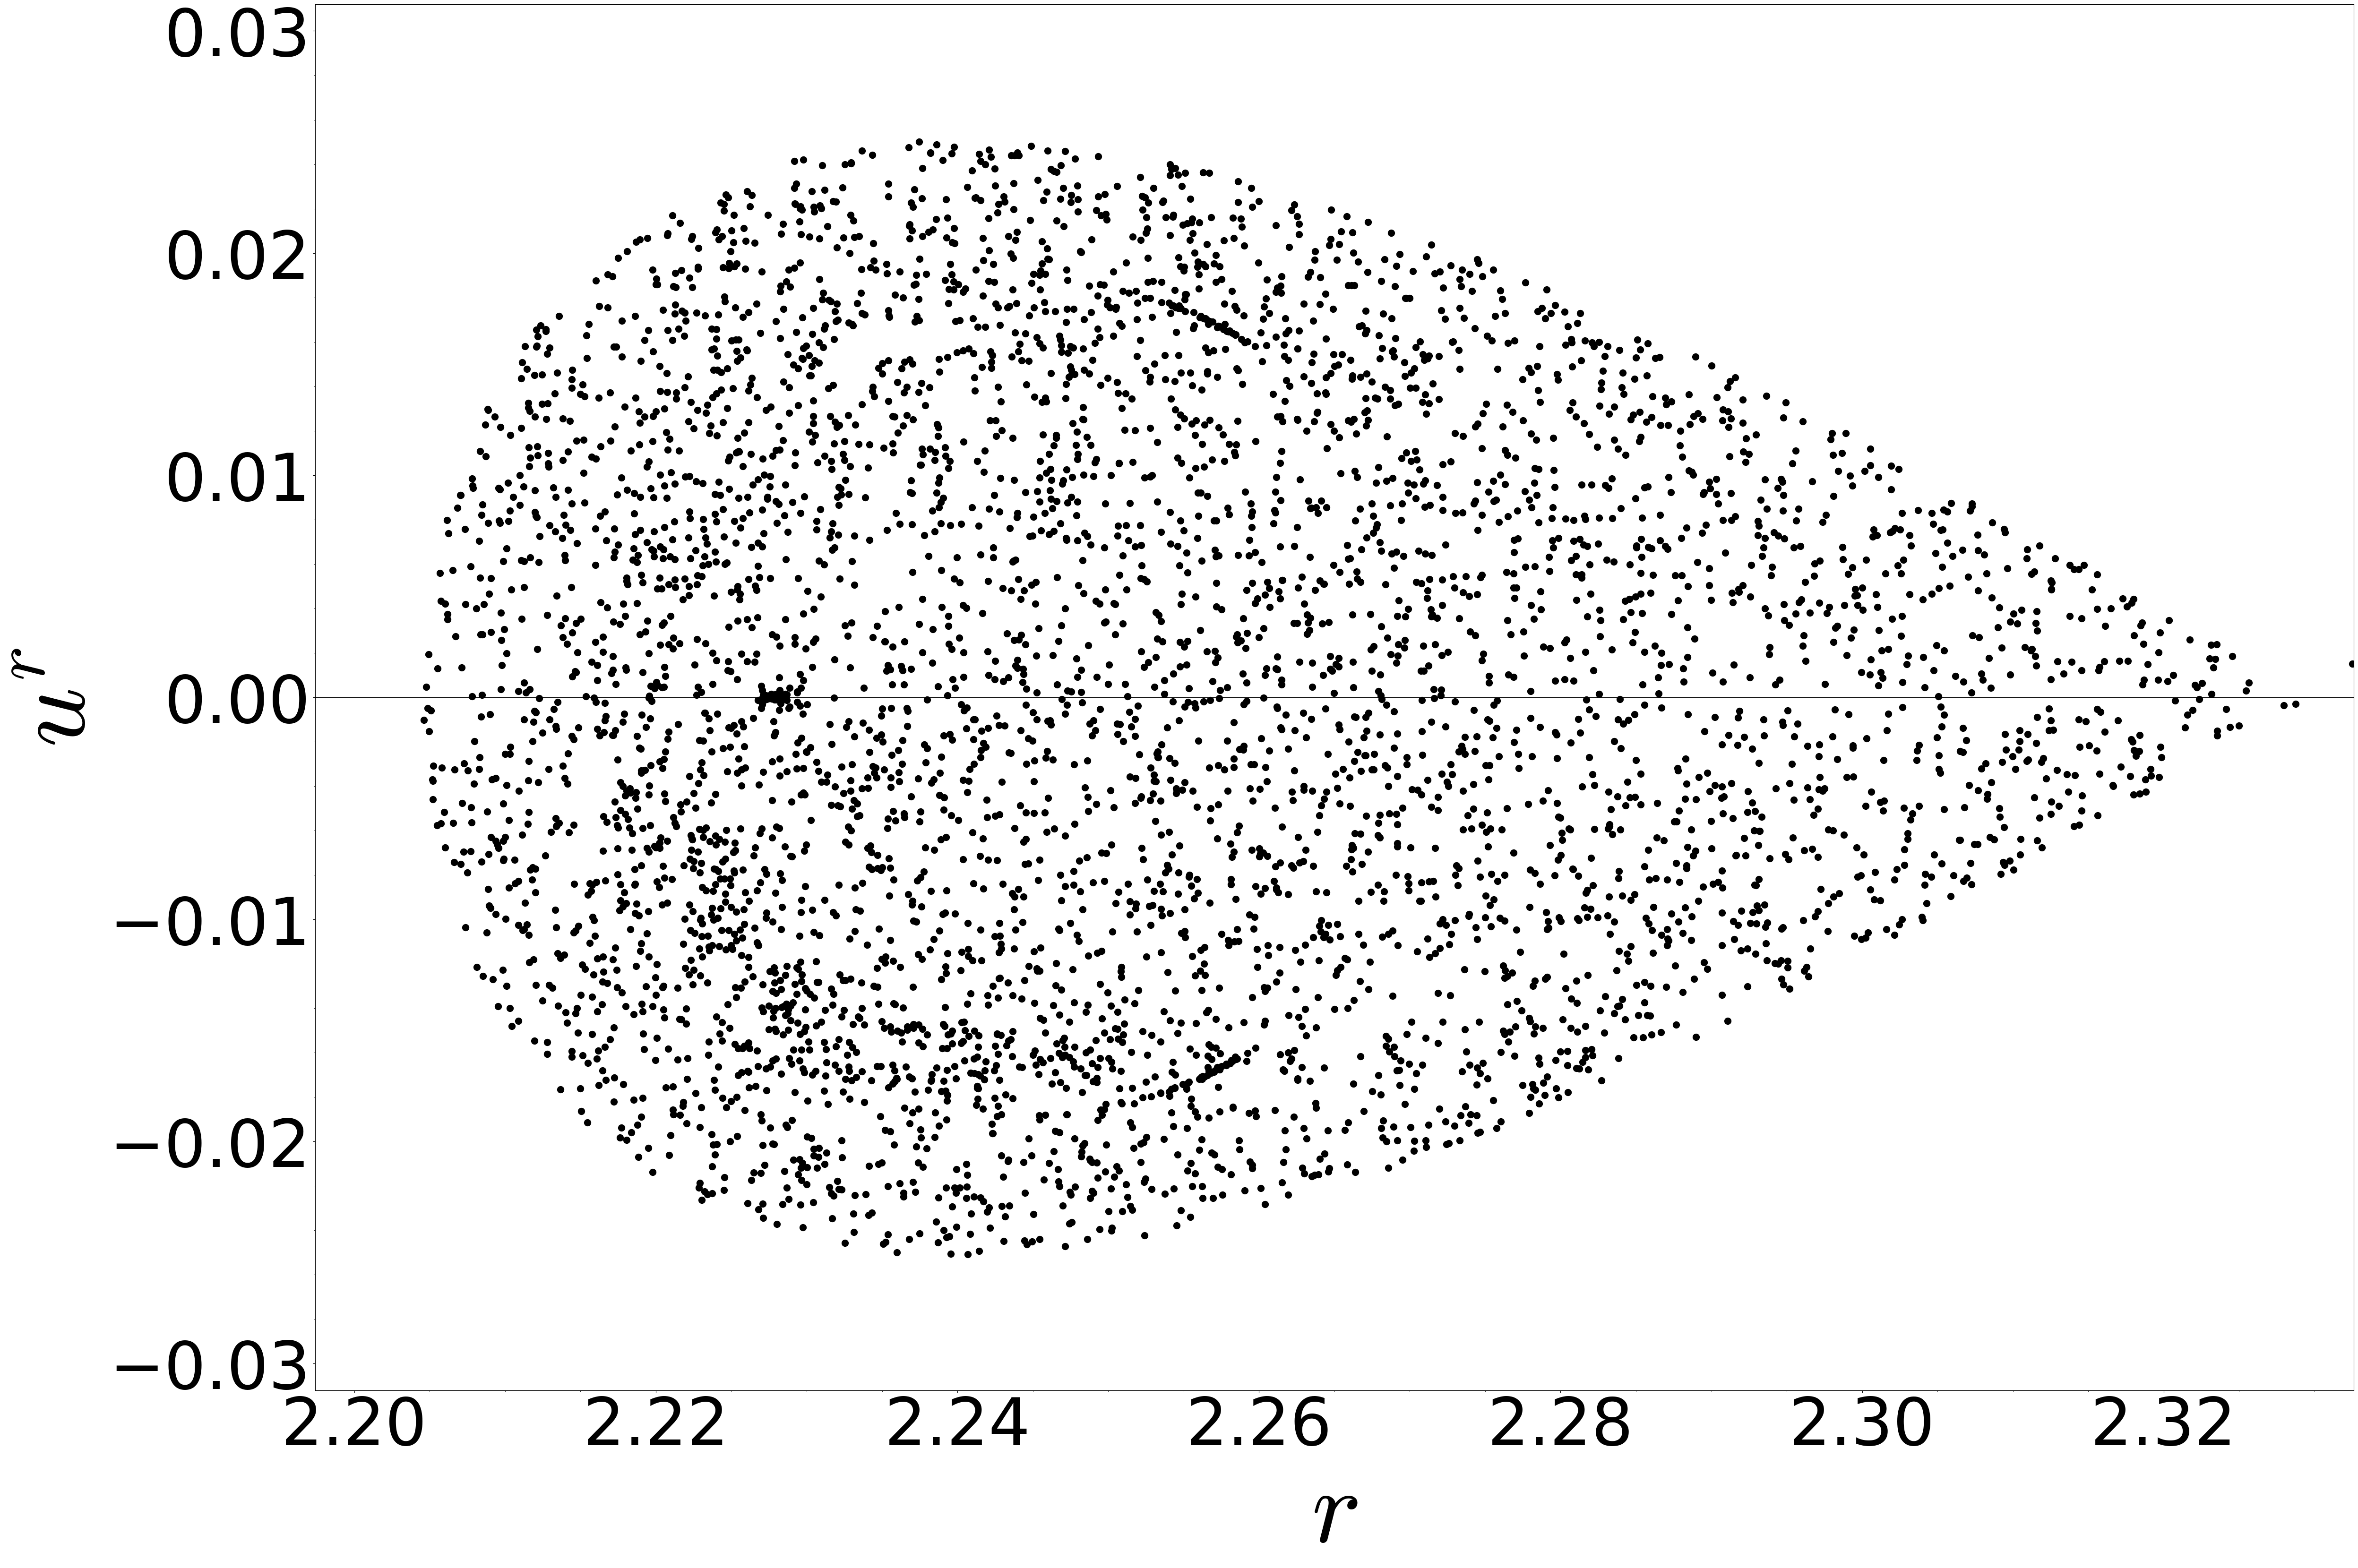

In [15]:
graphc=scatter_plot(gg,aspect_ratio='automatic',figsize=[50,50],alpha=1,markersize=100,zorder=1,edgecolor='black',facecolor='black',frame=True)
show(graphc,xmin=2.2,xmax=2.33,ymin=-0.03,ymax=0.03,fontsize=100,figsize=50,frame=True,axes_labels=[r'$r$', r'$u^r$']) 

We plot the **$z$-component** of the position of the photon as a time series.

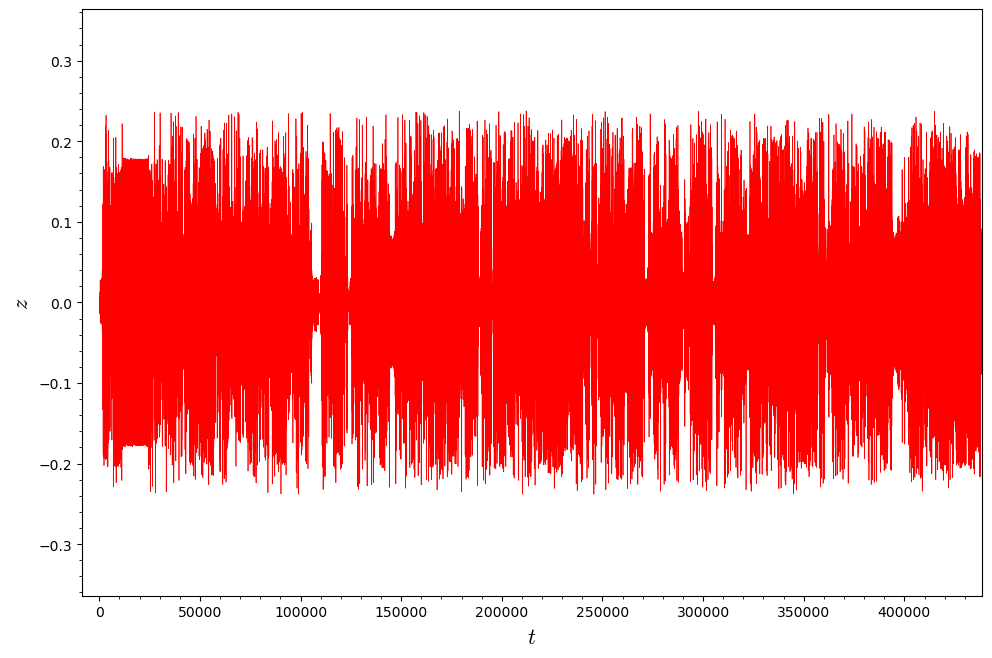

In [24]:
zt=[]
for i in range (0,len(sol)):
    zt.append([sol[i][1],sol[i][2]*cos(sol[i][3])])
graphzt=list_plot(zt,plotjoined=True,thickness=0.5,frame=True,zorder=2, axes=False,color='red')
show(graphzt,figsize=10,xmin=0,xmax=len(loop)/2,ymin=-0.35,ymax=0.35,fontsize=10,axes_labels=[r'$t$', r'$ z$'])


We perform a fast-Fourier Transform on the $z$-component time series using **scipy.fft**, in order to get the Power Spectra.

In [17]:
size=len(zt)-1
fft_data=FFT(size)

In [18]:
for j in range(size):
    fft_data[j]=zt[j][1]

In [19]:
fft_data.forward_transform()

In [20]:
deltaX=2*pi/size
fft_freq=[[0,0] for k in range((size)/2)]
for j in range((size)/2):
    fft_freq[j][0]=j*deltaX
    fft_freq[j][1]=deltaX*abs(vector(fft_data[j]))^2

In [21]:
graphps=list_plot(fft_freq,plotjoined=True,scale='loglog',thickness=0.1,color='red',frame=True,)

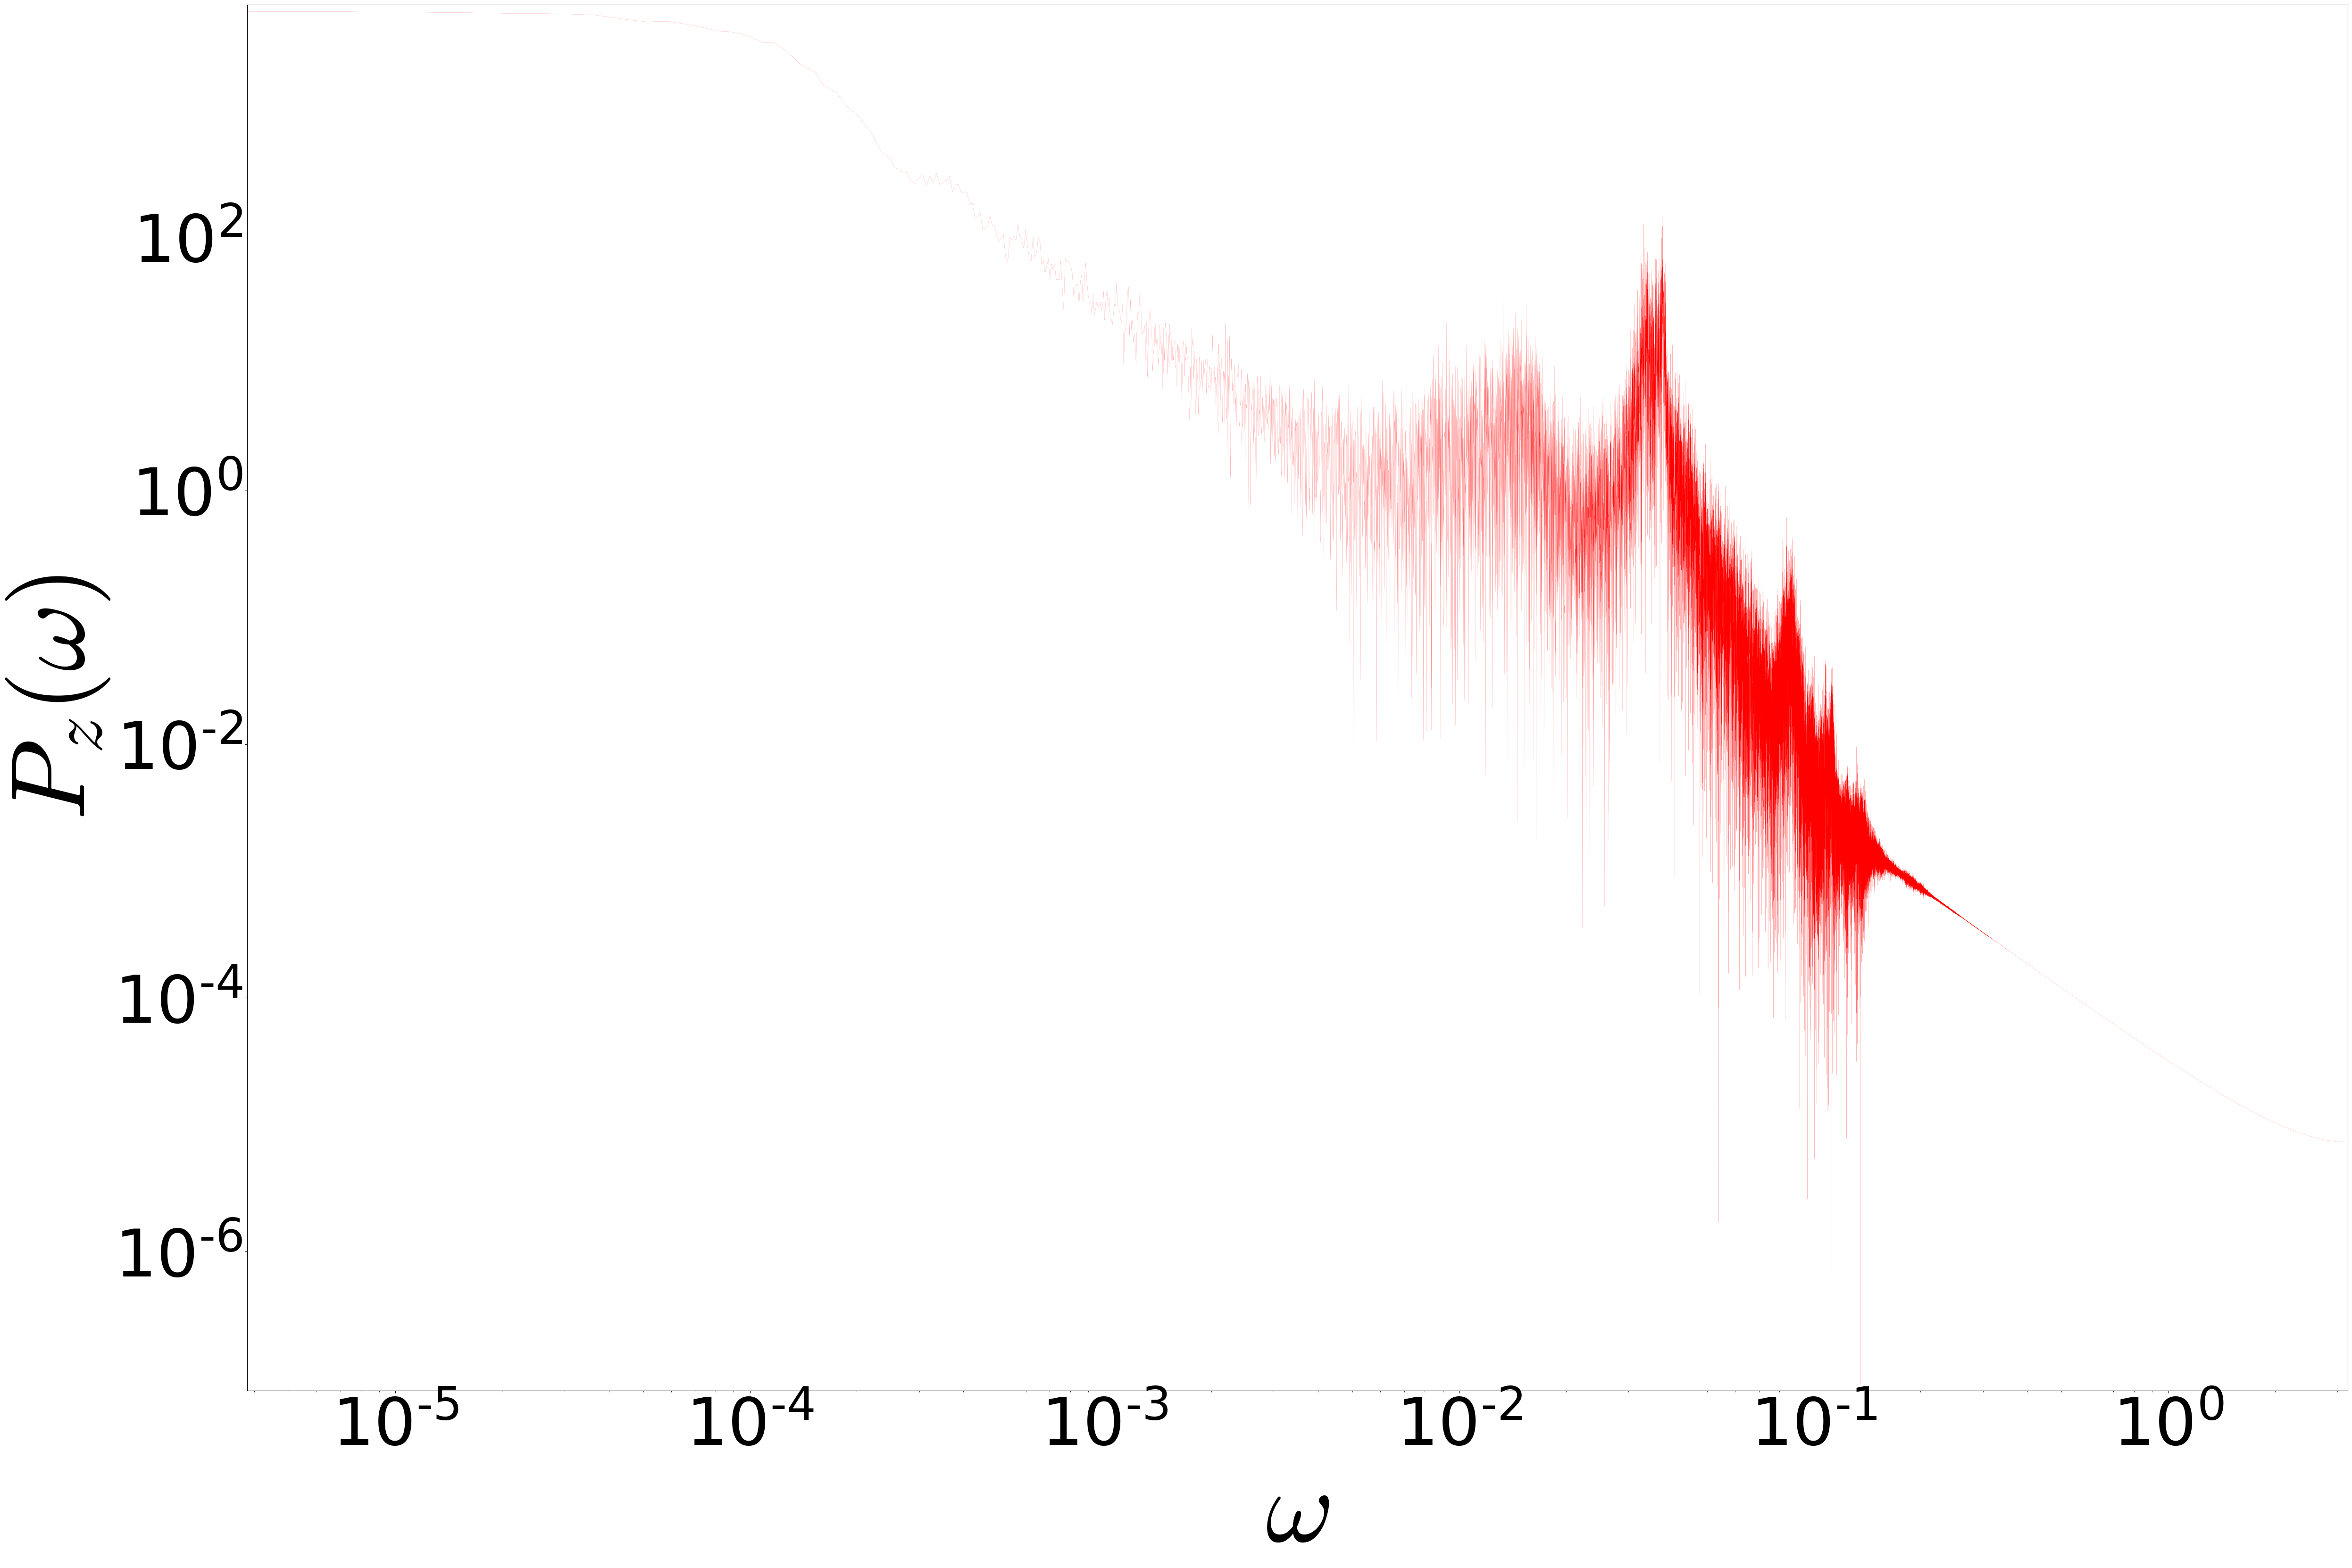

In [23]:
show(graphps,figsize=50,fontsize=100,axes_labels=[r'$\omega$', r'$P_z ( \omega)$'])

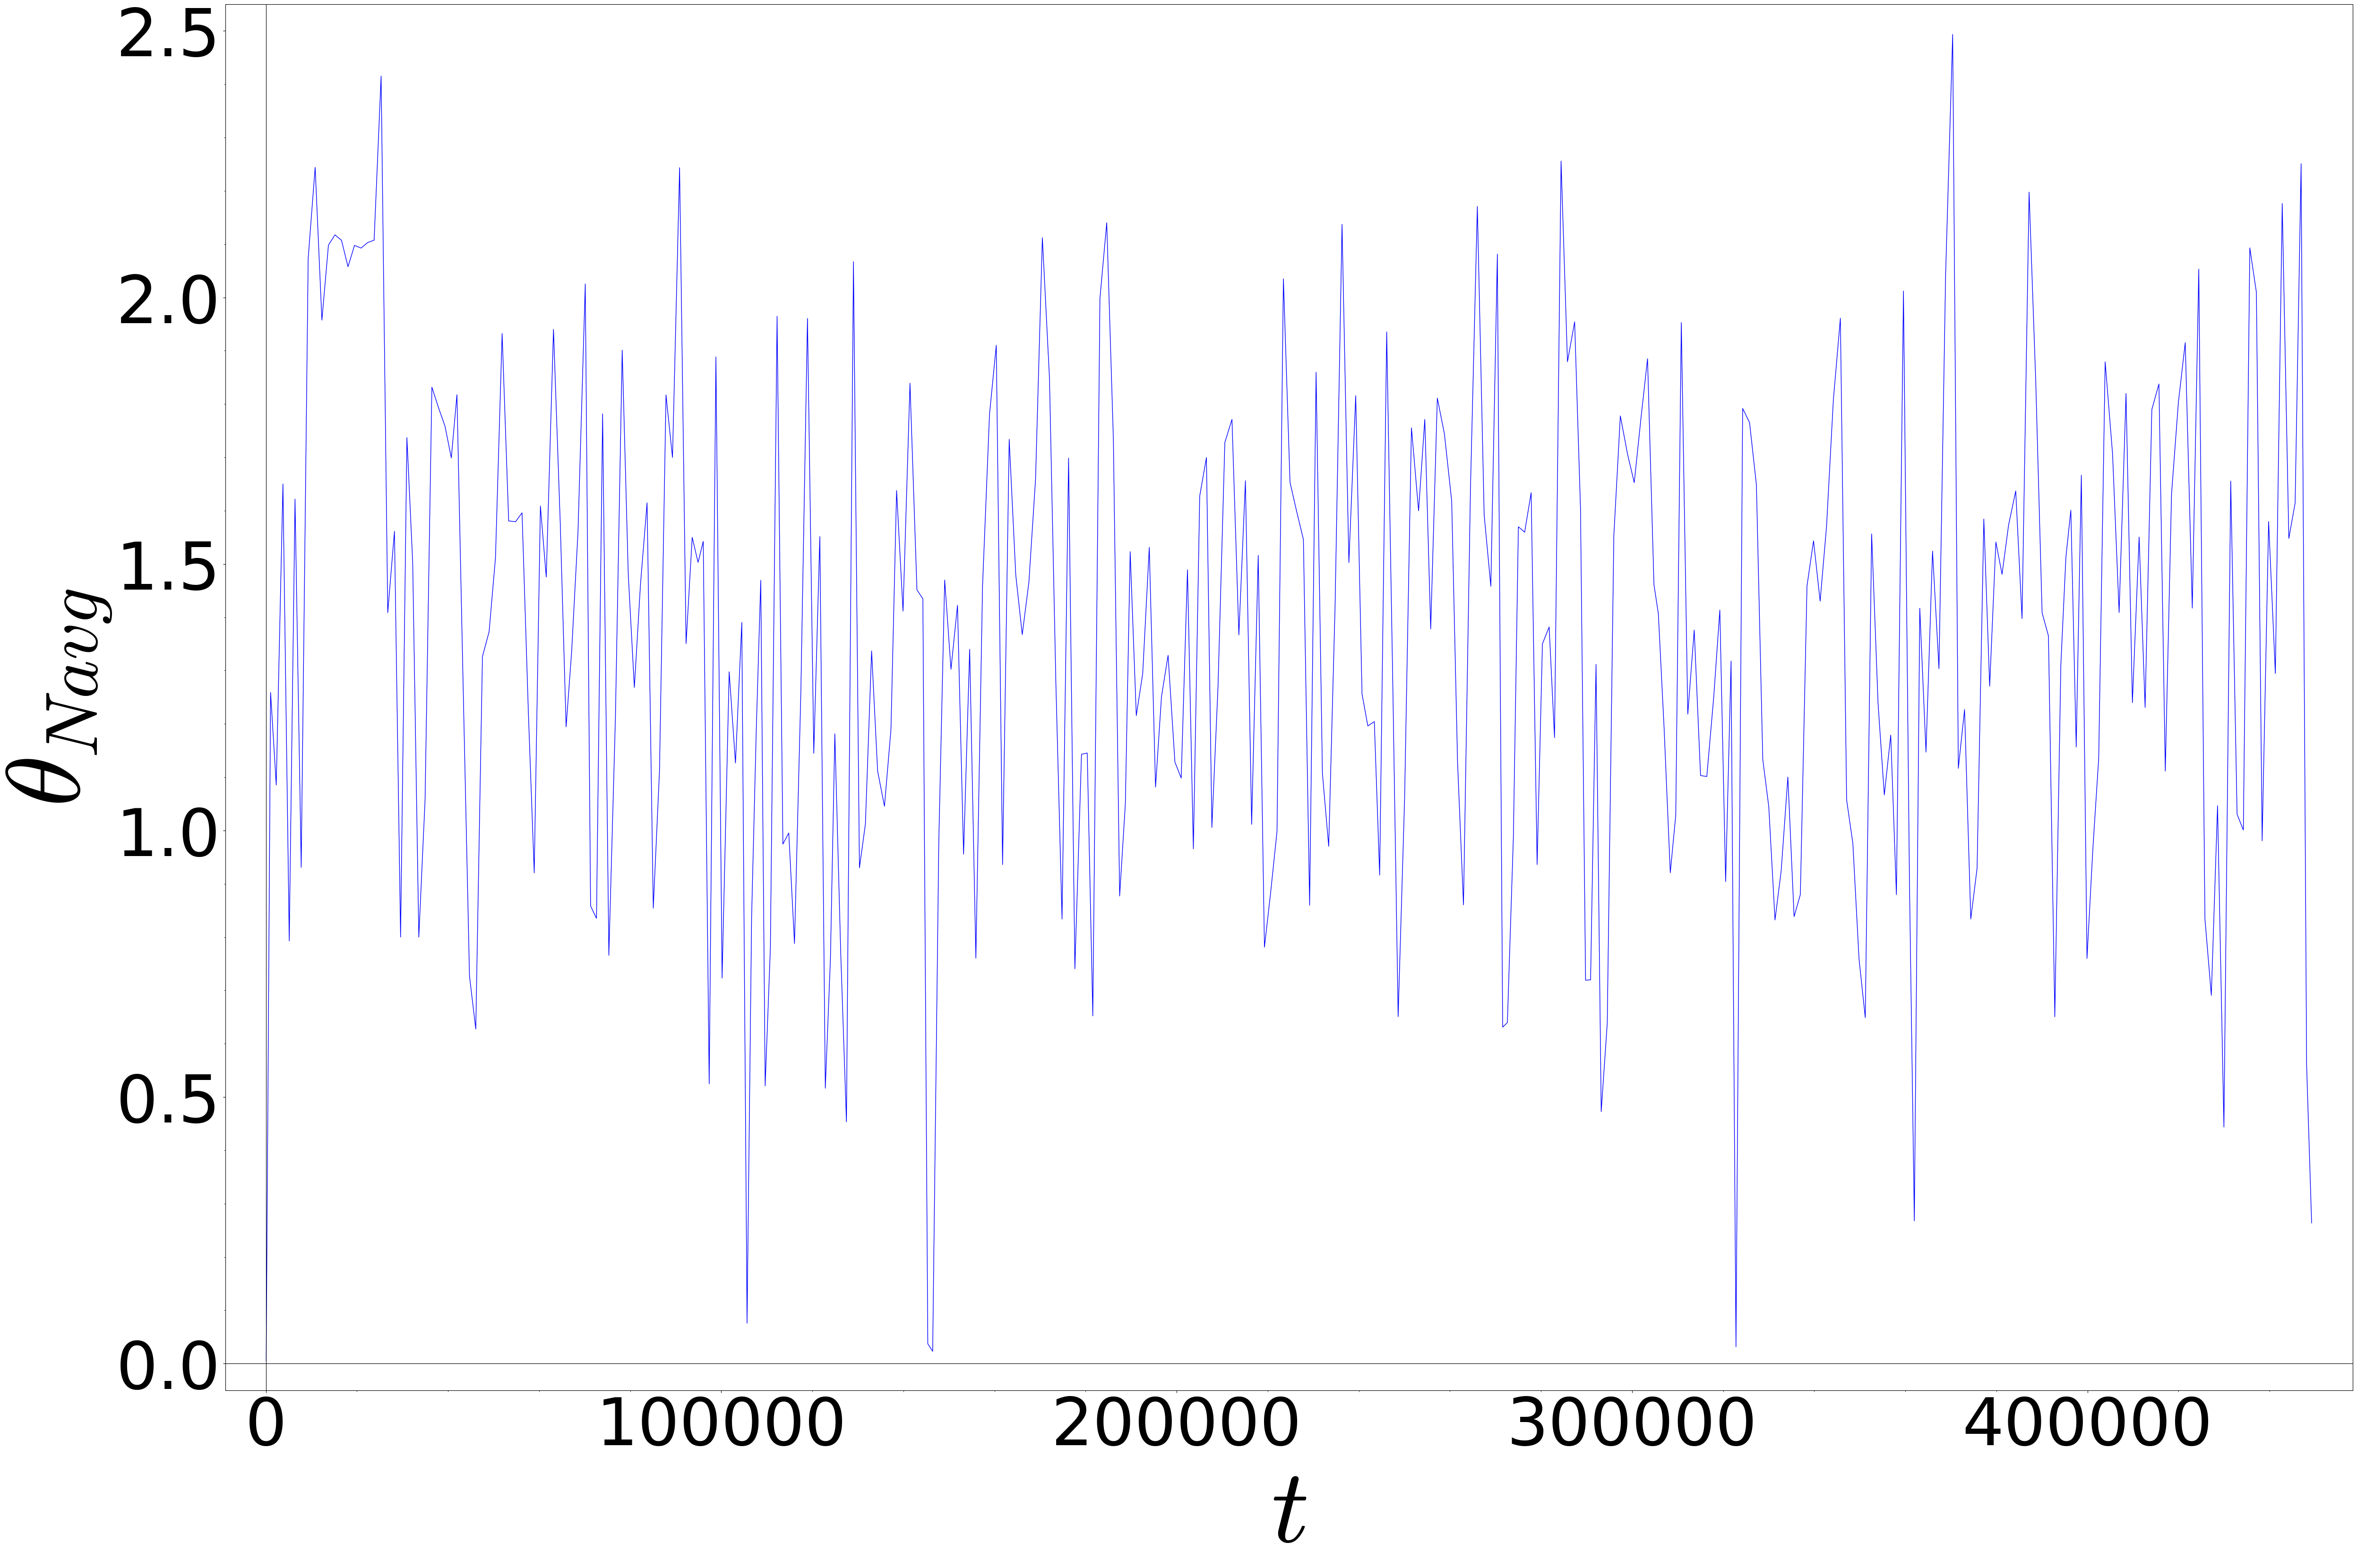

In [25]:

rn=[]
n=0
ang1=0
rn0=0
for i in range (len(gg)-1):
    
    c=vector([2.24,0])    
    a = vector([gg[i][0],gg[i][1]])
    
    b = vector([gg[i+1][0],gg[i+1][1]])
    c1=a-c
    c2=b-c
    dotproduct = c1.dot_product(c2)
    myfraction = dotproduct/(norm(c1) * norm(c2))
    ang=arccos(myfraction).n()
    ang1+=ang
    
    if i % 15 == 0:
        
        rn0=ang1/15
        rn.append([list3[i][0][0],rn0])
        ang1=0
        
        
    
graphrot=list_plot(rn,plotjoined=True,thickness=1,zorder=1,frame=True,color='blue',base=10)   
show(graphrot,ymin=0,ymax=2.5,figsize=50,fontsize=100,axes_labels=[r'$t$', r'$\theta_{Navg}$'])

In [30]:
# This cell is ran occasionally, in order to better allign the average rotation number curve with the z-component's
# time-series. 
rn_trans=[]

for i in range(len(rn)):
    rn_trans.append([rn[i][0],rn[i][1]-2])
    
graphrot=list_plot(rn_trans,plotjoined=True,thickness=1,zorder=3,frame=True,color='blue',base=10)       

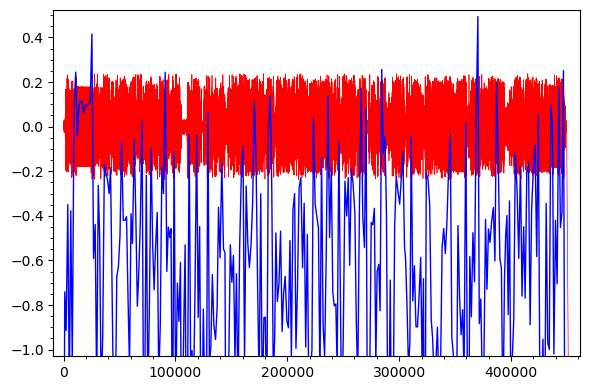

In [31]:
graph_all=graphrot+graphzt
show(graph_all,ymin=-1)